<a href="https://colab.research.google.com/github/EML-Labs/Feature_Analysis/blob/main/Experiment_1_K2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import wfdb
from pathlib import Path
from typing import Tuple, Optional, Dict


In [79]:
def compute_pc_l(R, l_max):
    """
    Compute p_c(l): probability of finding diagonals of length >= l
    R: recurrence matrix (NxN)
    l_max: maximum diagonal length to evaluate
    """
    N = R.shape[0]
    diag_lengths = []

    # extract diagonal line lengths

    # for k in range(0, N): # For Symmetric matrices
    for k in range(-N + 1, N):
        diag = np.diagonal(R, offset=k)
        # print("Diagonal now:", diag)
        count = 0
        for val in diag:
            if val == 1:
                count += 1
            else:
                if count > 0:
                    diag_lengths.append(count)
                count = 0
        if count > 0:
            diag_lengths.append(count)

    diag_lengths = np.array(diag_lengths)
    # print("Diagonal Lengths:", diag_lengths)

    pc = []
    for l in range(1, l_max + 1):
        pc.append(np.sum(diag_lengths >= l))

    pc = np.array(pc, dtype=float)
    pc /= pc[0]  # normalize by the diagonal
    return pc

In [80]:
def log_pc(pc):
  """ Safe way to get log of pc"""
  pc = np.clip(pc, 1e-12, None)
  return np.log(pc)

In [121]:
def detect_scaling_region_and_estimate_K2(l_vals, log_pc_vals, min_len=3, r2_threshold=0.95, min_slope = -0.001):
    """
    Automatically detect the asymptotic diagonal-length scaling region
    Returns (l_start, l_end)

    """
    best_score = -np.inf
    best_region = None
    K2 = None

    for i in range(len(l_vals)):
        if l_vals[i] < 3:
            continue
        for j in range(i + min_len, len(l_vals) + 1):
            x = l_vals[i:j].reshape(-1, 1)
            # print("x:", x)
            y = log_pc_vals[i:j]
            # print("y:", y)
            model = LinearRegression().fit(x, y)
            r2 = model.score(x, y)
            # print("r2:", r2)
            slope = model.coef_[0]
            # print("slope:", slope)

            # if r2 >= r2_threshold and slope < 0: # Strictly negative
            if r2 >= r2_threshold and slope <= min_slope:
                length = j - i
                # Just prioritize longest good fit
                # score = length
                mean_l = np.mean(l_vals[i:j])
                # score = length / mean_l
                score = length * np.log(mean_l + 1)

                if score > best_score:
                    best_score = score
                    best_region = (i, j)
                    K2 = -slope

    return best_region, K2

In [117]:
def plot_scaling_region(l_vals, log_pc_vals, region):
  plt.figure(figsize=(10, 6))
  plt.plot(l_vals, log_pc_vals, 'o-', color='steelblue',
             markersize=8, linewidth=2, label='Data')

  plt.plot(l_vals, log_pc_vals, 'o-', markersize=8, linewidth=2)
  if region is not None:
    i, j = region
    region_l = l_vals[i:j]
    region_log_pc = log_pc_vals[i:j]
    plt.plot(region_l, region_log_pc, 'o', color='red',
                 markersize=12, label='Scaling region', zorder=5)
  plt.xlabel('Diagonal length l')
  plt.ylabel('ln(p_c(l))')
  plt.title('Log probability vs diagonal length')
  plt.grid(True, alpha=0.3)
  plt.legend(fontsize=11)
  plt.tight_layout()
  plt.show()


In [6]:
class SegmentExtractor:
    """Helper functions to extract pre-AF and AF data from extracted segments"""

    def __init__(self, extracted_segments_dir: str, extraction_report_path: str):

        self.segments_dir = Path(extracted_segments_dir)
        self.report_df = pd.read_csv(extraction_report_path)

    def get_segment_info(self, segment_name: str) -> Optional[Dict]:

        row = self.report_df[self.report_df['Segment_Name'] == segment_name]
        if row.empty:
            print(f"Segment {segment_name} not found in extraction report")
            return None
        return row.iloc[0].to_dict()

    def extract_data(self, segment_name: str, extract_type: str) -> Tuple[Optional[np.ndarray], Optional[Dict]]:
        # Get segment info from report
        info = self.get_segment_info(segment_name)
        if info is None:
            return None, None
        try:
            # Load the full record
            record_path = self.segments_dir / segment_name
            record = wfdb.rdrecord(str(record_path))
            annotation = wfdb.rdann(str(record_path), 'atr')

            fs = int(record.fs)
            pre_af_minutes = info['Pre_AF_Minutes_Extracted']
            af_duration_minutes = info['AF_Duration_Minutes']

            # Calculate pre-AF samples (pre-AF is at the beginning of the segment)
            pre_af_samples = int(pre_af_minutes * 60 * fs)
            af_samples = int(af_duration_minutes * 60 * fs)

            af_start = pre_af_samples
            af_end = pre_af_samples + af_samples

            if extract_type == 'preaf':
                extracted_data = record.p_signal[:pre_af_samples, :]
                minutes_extracted = pre_af_minutes
                samples_extracted = pre_af_samples
            else:
                extracted_data = record.p_signal[af_start:af_end, :]
                minutes_extracted = af_duration_minutes
                samples_extracted = af_samples

            # Load QRS annotations
            try:
                qrs_ann = wfdb.rdann(str(record_path), 'qrs')
                if extract_type == 'preaf':
                    qrs_mask = qrs_ann.sample < pre_af_samples
                    qrs_samples = qrs_ann.sample[qrs_mask]
                else:
                    qrs_mask = (qrs_ann.sample >= af_start) & (qrs_ann.sample < af_end)
                    qrs_samples = qrs_ann.sample[qrs_mask] - af_start
                qrs_symbols = [qrs_ann.symbol[i] for i in range(len(qrs_ann.symbol))
                                  if qrs_mask[i]]
            except:
                qrs_samples = np.array([])
                qrs_symbols = []

            metadata = {
                'segment_name': segment_name,
                'record_id': info['Record_ID'],
                'episode_number': info['Episode_Number'],
                'duration_minutes': minutes_extracted,
                'duration_seconds': minutes_extracted * 60,
                'n_samples': samples_extracted,
                'sampling_frequency': fs,
                'n_channels': extracted_data.shape[1],
                'signal_names': record.sig_name[:extracted_data.shape[1]],
                'units': record.units[:extracted_data.shape[1]],
                'qrs_samples': qrs_samples,
                'qrs_symbols': qrs_symbols,
                'n_beats': len(qrs_samples)
            }

            if(extract_type == 'preaf'):
                print(f"✓ Extracted pre-AF data for {segment_name}: "
                  f"{minutes_extracted:.1f} min, {len(qrs_samples)} beats")
            else:
                print(f"✓ Extracted AF data for {segment_name}: "
                  f"{minutes_extracted:.1f} min, {len(qrs_samples)} beats")

            return extracted_data, metadata

        except Exception as e:
            print(f"Failed to extract data for {segment_name}: {e}")
            return None, None

    def extract_preaf_data(self, segment_name: str) -> Tuple[Optional[np.ndarray], Optional[Dict]]:
        return self.extract_data(segment_name, 'preaf')

    def extract_af_data(self, segment_name: str) -> Tuple[Optional[np.ndarray], Optional[Dict]]:
        return self.extract_data(segment_name, 'af')


    def extract_both(self, segment_name: str) -> Dict:
        preaf_ecg, preaf_meta = self.extract_preaf_data(segment_name)
        af_ecg, af_meta = self.extract_af_data(segment_name)

        return {
            'preaf': (preaf_ecg, preaf_meta),
            'af': (af_ecg, af_meta)
        }

    def get_rr_intervals(self, qrs_samples: np.ndarray, fs: int) -> Tuple[np.ndarray, np.ndarray]:
        if len(qrs_samples) < 2:
            return np.array([]), np.array([])

        beat_times = qrs_samples / fs
        rr_intervals = np.diff(beat_times)

        return rr_intervals, beat_times[1:]

# Unit Tests


In [9]:
# Initialize extractor
extractor = SegmentExtractor(
    extracted_segments_dir='/content/drive/MyDrive/AFDB/AFDB',
    extraction_report_path='/content/drive/MyDrive/AFDB/AFDB/EXTRACTION_REPORT.csv'
)

# Example 1: Extract pre-AF data only
segment_name = '08434_ep01'
preaf_ecg, preaf_meta = extractor.extract_preaf_data(segment_name)

if preaf_ecg is not None:
    print(f"\nPre-AF ECG shape: {preaf_ecg.shape}")
    print(f"Duration: {preaf_meta['duration_minutes']:.1f} minutes")
    print(f"Sampling rate: {preaf_meta['sampling_frequency']} Hz")
    print(f"Number of beats: {preaf_meta['n_beats']}")

    # Calculate RR intervals
    if len(preaf_meta['qrs_samples']) > 0:
        rr_intervals, rr_times = extractor.get_rr_intervals(
            preaf_meta['qrs_samples'],
            preaf_meta['sampling_frequency']
        )
        print(f"Mean RR interval: {np.mean(rr_intervals):.3f} s")
        print(f"Heart rate: {60/np.mean(rr_intervals):.1f} bpm")

# Example 2: Extract AF data only
af_ecg, af_meta = extractor.extract_af_data(segment_name)

if af_ecg is not None:
    print(f"\nAF ECG shape: {af_ecg.shape}")
    print(f"Duration: {af_meta['duration_minutes']:.1f} minutes")
    print(f"Number of beats: {af_meta['n_beats']}")

# Example 3: Extract both at once
data = extractor.extract_both(segment_name)
preaf_ecg, preaf_meta = data['preaf']
af_ecg, af_meta = data['af']

# Example 4: Process all segments in the report
print("\n" + "="*60)
print("Processing all segments:")
print("="*60)

for idx, row in extractor.report_df.iterrows():
    segment_name = row['Segment_Name']
    data = extractor.extract_both(segment_name)


✓ Extracted pre-AF data for 08434_ep01: 120.0 min, 8330 beats

Pre-AF ECG shape: (1800000, 2)
Duration: 120.0 minutes
Sampling rate: 250 Hz
Number of beats: 8330
Mean RR interval: 0.864 s
Heart rate: 69.4 bpm
✓ Extracted AF data for 08434_ep01: 5.2 min, 520 beats

AF ECG shape: (78224, 2)
Duration: 5.2 minutes
Number of beats: 520
✓ Extracted pre-AF data for 08434_ep01: 120.0 min, 8330 beats
✓ Extracted AF data for 08434_ep01: 5.2 min, 520 beats

Processing all segments:
✓ Extracted pre-AF data for 04043_ep02: 120.0 min, 12329 beats
✓ Extracted AF data for 04043_ep02: 1.1 min, 129 beats
✓ Extracted pre-AF data for 04048_ep03: 120.0 min, 8129 beats
✓ Extracted AF data for 04048_ep03: 2.6 min, 388 beats
✓ Extracted pre-AF data for 04126_ep05: 120.0 min, 7840 beats
✓ Extracted AF data for 04126_ep05: 1.3 min, 149 beats
✓ Extracted pre-AF data for 04746_ep01: 120.0 min, 6790 beats
✓ Extracted AF data for 04746_ep01: 205.8 min, 19246 beats
✓ Extracted pre-AF data for 04908_ep07: 120.0 min, 

R: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
pc: [1.         0.34306957 0.16303771 0.0929368  0.06956984 0.05257568
 0.04036113 0.02973978 0.02071163 0.01433882 0.01327669 0.01115242
 0.00849708 0.00690388 0.00531067 0.00477961 0.00477961 0.00477961
 0.00424854 0.00371747 0.00371747 0.0031864  0.0031864  0.00212427
 0.00212427 0.0015932  0.0015932  0.0015932  0.00106213 0.00106213
 0.00106213 0.00106213 0.00106213 0.00106213 0.00106213 0.00106213
 0.00106213 0.00106213 0.00106213 0.00106213]
lg_pc: [ 0.         -1.06982202 -1.81377378 -2.37583555 -2.66542421 -2.94550168
 -3.20988819 -3.51526984 -3.87705988 -4.24478466 -4.3217457  -4.49609909
 -4.76803281 -4.97567217 -5.23803644 -5.34339695 -5.34339695 -5.34339695
 -5.46117999 -5.59471138 -5.59471138 -5.74886206 -5.74886206 -6.15432717
 -6.15432717 -6.44200924 -6.44200924 -6.44200924 -6.84747435 -6.84747435
 -6.84747435 -6.8

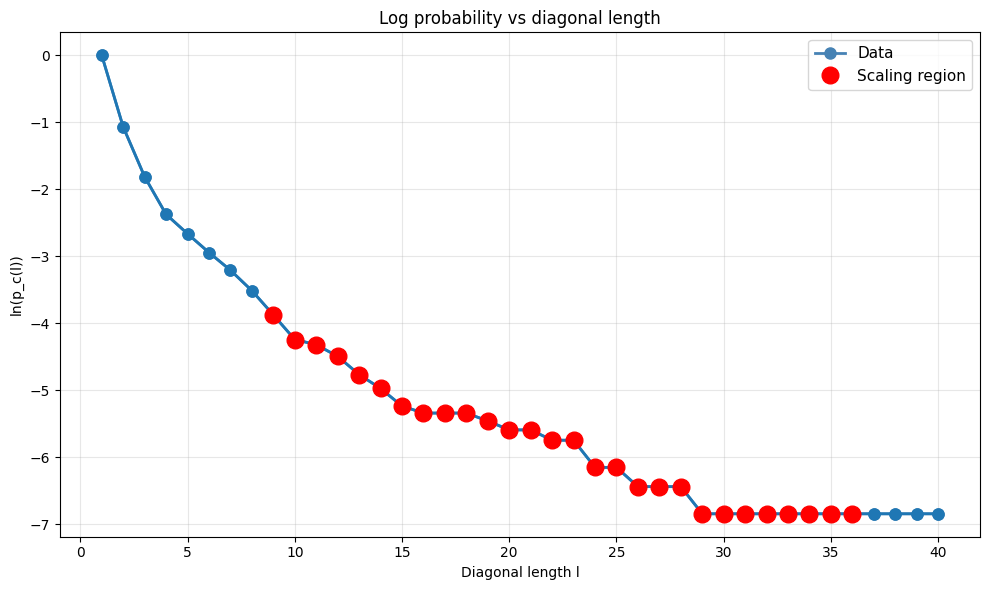

In [122]:
"""
Plotting the scaling region.

"""

np.random.seed(0)
N = 200
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 40
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)
lg_pc = log_pc(pc)
print("lg_pc:", lg_pc)
l_vals = np.arange(1, l_max + 1)
print("l_vals:", l_vals)
region, K2  = detect_scaling_region_and_estimate_K2(l_vals, lg_pc, 5)
print("K2:", K2)
print("region:", region)
plot_scaling_region(l_vals, lg_pc, region)

In [88]:
"""
Unit test for the calculation of K2.

The scaling region was automatically identified as the
longest interval of diagonal lengths exhibiting a sufficiently
linear relationship (R² ≥ 0.95) with a non-positive slope (≤ -0.01),
weighted toward larger diagonal lengths to ensure asymptotic validity.
Correlation entropy was then estimated from the slope of this region.

"""

np.random.seed(0)
N = 200
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 50
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)
lg_pc = log_pc(pc)
print("lg_pc:", lg_pc)
l_vals = np.arange(1, l_max + 1)
print("l_vals:", l_vals)
region, K2  = detect_scaling_region_and_estimate_K2(l_vals, lg_pc, 5)
print("K2:", K2)
print("region:", region)

R: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
pc: [1.00000000e+00 3.43069570e-01 1.63037706e-01 9.29368030e-02
 6.95698354e-02 5.25756771e-02 4.03611259e-02 2.97397770e-02
 2.07116304e-02 1.43388210e-02 1.32766861e-02 1.11524164e-02
 8.49707913e-03 6.90387679e-03 5.31067446e-03 4.77960701e-03
 4.77960701e-03 4.77960701e-03 4.24853956e-03 3.71747212e-03
 3.71747212e-03 3.18640467e-03 3.18640467e-03 2.12426978e-03
 2.12426978e-03 1.59320234e-03 1.59320234e-03 1.59320234e-03
 1.06213489e-03 1.06213489e-03 1.06213489e-03 1.06213489e-03
 1.06213489e-03 1.06213489e-03 1.06213489e-03 1.06213489e-03
 1.06213489e-03 1.06213489e-03 1.06213489e-03 1.06213489e-03
 1.06213489e-03 5.31067446e-04 5.31067446e-04 5.31067446e-04
 5.31067446e-04 5.31067446e-04 5.31067446e-04 5.31067446e-04
 5.31067446e-04 5.31067446e-04]
lg_pc: [ 0.         -1.06982202 -1.81377378 -2.37583555 -2.66542421 -2.94

In [ ]:
np.random.seed(0)
N = 5
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 10
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)
lg_pc = np.log(pc)
print("lg_pc:", lg_pc)
lg_pc_safe = log_pc(pc)
print("lg_pc_safe:", lg_pc_safe)

In [4]:
#Checking pc_of_l functionality using random generator

# Synthetic recurrence matrix
np.random.seed(0)
N = 5
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 40
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)


Diagonal now: [1.]
Diagonal now: [0. 1.]
Diagonal now: [1. 0. 1.]
Diagonal now: [1. 1. 1. 1.]
Diagonal now: [1. 1. 1. 1. 1.]
Diagonal now: [1. 1. 1. 1.]
Diagonal now: [1. 1. 0.]
Diagonal now: [1. 1.]
Diagonal now: [1.]
Diagonal Lengths: [1 1 1 1 4 5 4 2 2 1]
R: [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
pc: [1.  0.5 0.3 0.3 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0. ]


In [5]:
# Checking pc_of_l functionality for symmetric matrix

R = [[1,0,1], [0,1,1], [1,1,1]]
R = np.array(R)
l_max = 5
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)

Diagonal now: [1]
Diagonal now: [0 1]
Diagonal now: [1 1 1]
Diagonal now: [0 1]
Diagonal now: [1]
Diagonal Lengths: [1 1 3 1 1]
R: [[1 0 1]
 [0 1 1]
 [1 1 1]]
pc: [1.  0.2 0.2 0.  0. ]
